In [31]:
import os
import numpy as np

# Paths to VOC directories
base_dir = '/Volumes/T7-apps/aml_dataset//VOC2012_train_val/VOC2012_train_val'
images_dir = os.path.join(base_dir, 'JPEGImages')
annotations_dir = os.path.join(base_dir, 'Annotations')
sets_dir = os.path.join(base_dir, 'ImageSets/Main')

# Function to read predefined splits
def get_files_from_split(file_path):
    with open(file_path, 'r') as f:
        files = [x.strip().split()[0] for x in f.readlines() if not x.startswith('#')]
    return files

# Get all files from trainval.txt
trainval_files = get_files_from_split(os.path.join(sets_dir, 'trainval.txt'))
np.random.shuffle(trainval_files)  # Shuffle to randomize the split

split_index = int(len(trainval_files) * 0.9)
train_files = trainval_files[:split_index]
val_files = trainval_files[split_index:]


In [32]:
from torch.utils.data import Dataset
from PIL import Image
import os
import random
from torchvision import transforms

class RotationDataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        """
        file_list: lista dei nomi dei file (es. ['2008_000001', ...])
        root_dir: cartella dove sono le immagini JPEG
        """
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform
        
        # Mappa le rotazioni in classi
        self.angle_to_label = {0: 0, 90: 1, 180: 2, 270: 3}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.root_dir, filename + ".jpg")
        
        image = Image.open(img_path).convert("RGB")
        
        # 1. Scegliamo una rotazione casuale
        angle = random.choice([0, 90, 180, 270])
        
        # 2. Ruotiamo l'immagine
        # Nota: expand=True adatta la dimensione se l'img non è quadrata
        rotated_image = image.rotate(-angle, expand=True) 
        
        # 3. Creiamo la label per la rotazione
        label_rotation = self.angle_to_label[angle]
        
        # 4. Applichiamo le trasformazioni standard (Resize, ToTensor, Normalize)
        if self.transform:
            rotated_image = self.transform(rotated_image)
            
        return rotated_image, label_rotation

# --- 1. Define the 96x96 Pipeline (Phase 1) ---
transform_pipeline_96 = transforms.Compose([
    transforms.Resize(128), 
    transforms.RandomCrop(96), 
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 2. Define the 128x128 Pipeline (Phase 1) ---
transform_pipeline_128 = transforms.Compose([
    transforms.Resize(160), 
    transforms.RandomCrop(128), 
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Define the 224x224 Pipeline (Phase 2 - Original) ---
transform_pipeline_224 = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Usa la tua lista 'train_files' generata nel tuo codice precedente
train_dataset = RotationDataset(train_files, images_dir, transform=transform_pipeline_128)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import time
import copy

# --- 1. CONFIGURAZIONE ---
BATCH_SIZE = 32
NUM_EPOCHS = 75
LEARNING_RATE = 0.01
PATIENCE = 7
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Usando device: {DEVICE}")

# --- 2. DATALOADERS ---
# Creiamo il dataset di validazione (assicurati di aver definito val_files come prima)
val_dataset = RotationDataset(val_files, images_dir, transform=transform_pipeline_96)

# Creiamo i generatori di batch
# --- 2. DATALOADERS ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 3. DEFINIZIONE DEL MODELLO ---
# Scarichiamo una ResNet18 pre-addestrata
model = models.resnet18(weights = None)

# Congeliamo i pesi (facoltativo, ma velocizza se hai pochi dati)
# per un task semplice come la rotazione, spesso conviene NON congelare tutto, 
# ma se vuoi farlo:
#for param in model.parameters():
#     param.requires_grad = False

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs),  # Hidden layer (maintains size or reduces)
    nn.ReLU(),                      # Non-linearity (Crucial!)
    nn.Linear(num_ftrs, 4)          # Output layer
)
model = model.to(DEVICE)

# --- 4. LOSS E OPTIMIZER ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


# --- 5. FUNZIONE DI TRAINING CON EARLY STOPPING ---
def train_model_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0  # Contatore per l'early stopping
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):

        if epoch == 25:
            print("Creating dataset with new 128x128 transforms...")
            train_dataset.transform = transform_pipeline_128
            val_loader.dataset.transform = transform_pipeline_128
            
            best_loss = float('inf')  
            epochs_no_improve = 0
            print(">>> Early Stopping resettato per la nuova fase.")

        if epoch == 50:
            print("Creating dataset with new 224x224 transforms...")
            train_dataset.transform = transform_pipeline_224
            val_loader.dataset.transform = transform_pipeline_224
            
            best_loss = float('inf')  
            epochs_no_improve = 0
            print(">>> Early Stopping resettato per la nuova fase.")

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Ogni epoca ha una fase di training e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.item() / len(dataloader.dataset) # .item() per scalare

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Salva metriche
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
                # --- EARLY STOPPING LOGIC ---
                # Aggiorna lo scheduler
                scheduler.step()

                # Se la loss migliora, salviamo il modello e resettiamo il contatore
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    # print("  -> Miglioramento rilevato, modello salvato.")
                else:
                    epochs_no_improve += 1
                    print(f"  -> Nessun miglioramento per {epochs_no_improve}/{patience} epoche.")

        print() # Rigo vuoto tra epoche

        # Se non miglioriamo per 'patience' epoche, fermiamo tutto
        if epochs_no_improve >= patience:
            print(f"Early Stopping attivato! Nessun miglioramento per {patience} epoche consecutive.")
            break

    time_elapsed = time.time() - start_time
    print(f'Training completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Miglior Val Loss: {best_loss:.4f}')

    # Carichiamo i pesi migliori (non gli ultimi)
    model.load_state_dict(best_model_wts)
    return model, history

# --- 6. AVVIO DEL TRAINING ---
trained_model, history = train_model_early_stopping(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler=scheduler, 
    num_epochs=NUM_EPOCHS, 
    patience=PATIENCE
)

# --- 7. SALVATAGGIO ---
torch.save(trained_model.state_dict(), 'rotation_model_optimized.pth')
print("Modello ottimizzato salvato.")

Usando device: mps
Epoch 1/75
----------
train Loss: 1.3451 Acc: 0.3414
val Loss: 1.3570 Acc: 0.3951

Epoch 2/75
----------
train Loss: 1.2711 Acc: 0.4273
val Loss: 1.2713 Acc: 0.4463

Epoch 3/75
----------
train Loss: 1.2482 Acc: 0.4421
val Loss: 1.2493 Acc: 0.4489

Epoch 4/75
----------
train Loss: 1.2313 Acc: 0.4529
val Loss: 1.2487 Acc: 0.4333

Epoch 5/75
----------
train Loss: 1.2261 Acc: 0.4622
val Loss: 1.2526 Acc: 0.4549
  -> Nessun miglioramento per 1/7 epoche.

Epoch 6/75
----------
train Loss: 1.2190 Acc: 0.4650
val Loss: 1.2140 Acc: 0.4688

Epoch 7/75
----------
train Loss: 1.2076 Acc: 0.4684
val Loss: 1.2250 Acc: 0.4783
  -> Nessun miglioramento per 1/7 epoche.

Epoch 8/75
----------
train Loss: 1.1959 Acc: 0.4755
val Loss: 1.2248 Acc: 0.4844
  -> Nessun miglioramento per 2/7 epoche.

Epoch 9/75
----------
train Loss: 1.1929 Acc: 0.4826
val Loss: 1.2392 Acc: 0.4506
  -> Nessun miglioramento per 3/7 epoche.

Epoch 10/75
----------
train Loss: 1.1785 Acc: 0.4974
val Loss: 1.

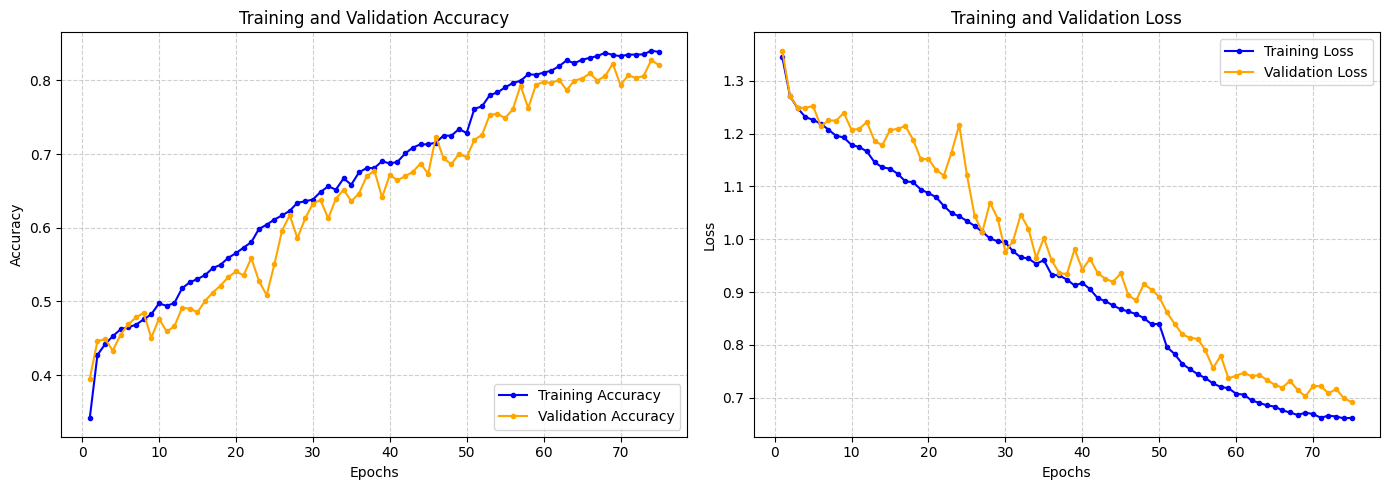

In [34]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    # Creiamo un array con il numero delle epoche effettive
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # --- GRAFICO 1: ACCURACY ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- GRAFICO 2: LOSS ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Esegui la funzione passando la history ottenuta dal training
if 'history' in locals():
    plot_training_results(history)
else:
    print("Errore: Variabile 'history' non trovata. Assicurati che la funzione di training la restituisca.")

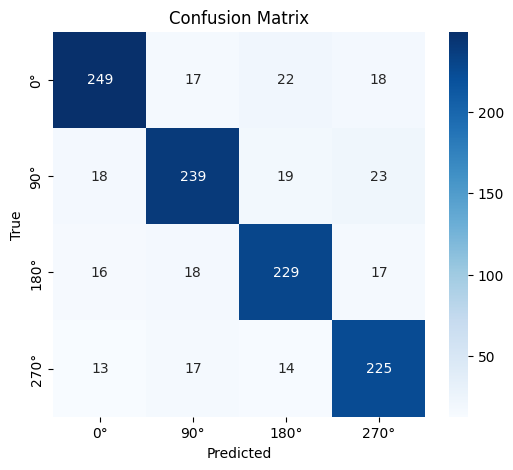

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, val_loader, class_names):
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move to CPU and append to lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot using Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names (based on your rotation angles)
class_names = ['0°', '90°', '180°', '270°']

# Run the confusion matrix function
plot_confusion_matrix(model, val_loader, class_names)

Running evaluation on validation set...

1. CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.8242    0.8036    0.8137       280
         90°     0.7942    0.8459    0.8192       292
        180°     0.8674    0.7763    0.8193       295
        270°     0.7941    0.8467    0.8196       287

    accuracy                         0.8180      1154
   macro avg     0.8200    0.8181    0.8180      1154
weighted avg     0.8202    0.8180    0.8180      1154


GENERATING GENERAL ROC CURVE


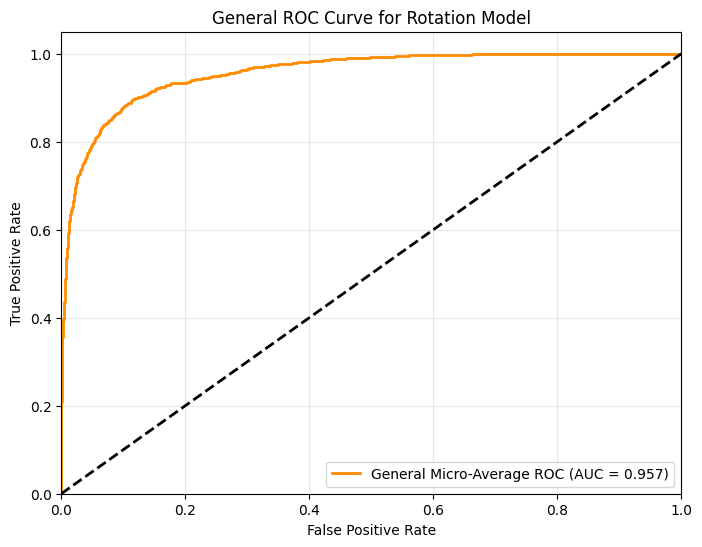


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


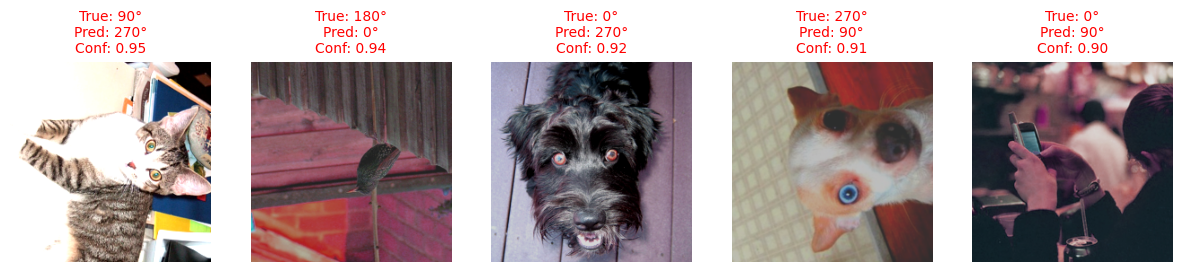

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import torch
import torch.nn.functional as F

def detailed_model_analysis(model, val_loader, class_names, device):
    model.eval()
    
    # Store all labels and outputs
    all_labels = []
    all_preds = []
    all_probs = [] # Raw probabilities for ROC
    
    # Store misclassified examples for visualization
    # Format: (probability, predicted_class, true_class, image_tensor)
    misclassified_examples = []

    print("Running evaluation on validation set...")
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # Apply Softmax to get probabilities (0 to 1)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            # Save data
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Collect errors for visualization
            # We look for cases where pred != label
            matches = preds.eq(labels)
            for i, is_correct in enumerate(matches):
                if not is_correct:
                    # Store data to visualize later
                    # We store the confidence score of the WRONG prediction
                    conf = probs[i][preds[i]].item()
                    misclassified_examples.append({
                        'conf': conf,
                        'pred': preds[i].item(),
                        'true': labels[i].item(),
                        'img': inputs[i].cpu()
                    })

    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    n_classes = len(class_names)

    # --- 1. Classification Report (F1, Precision, Recall) ---
    print("\n" + "="*30)
    print("1. CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # --- 2. ROC Curves (One-vs-Rest) ---
    print("\n" + "="*40)
    print("GENERATING GENERAL ROC CURVE")
    print("="*40)

    # Binarize labels (e.g., 0 -> [1, 0, 0, 0])
    y_true = np.array(all_labels)
    y_probs = np.array(all_probs)
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Compute Micro-Average ROC curve and ROC area
    # .ravel() flattens the arrays to calculate metrics globally across all classes
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'General Micro-Average ROC (AUC = {roc_auc:0.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line (random guess)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('General ROC Curve for Rotation Model')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # --- 3. Top-Confidence Errors (Visual Inspection) ---
    print("\n" + "="*30)
    print("3. TOP CONFIDENT FAILURES (Visual Inspection)")
    print("="*30)
    print("These are images where the model was very confident but WRONG.")
    
    # Sort errors by confidence (descending)
    misclassified_examples.sort(key=lambda x: x['conf'], reverse=True)
    
    # Plot top 5 errors
    num_show = min(5, len(misclassified_examples))
    if num_show > 0:
        fig, axes = plt.subplots(1, num_show, figsize=(15, 4))
        if num_show == 1: axes = [axes]
        
        for i in range(num_show):
            data = misclassified_examples[i]
            
            # Un-normalize image for display
            # Assuming ImageNet stats: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            img = data['img'].clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            # Display
            ax = axes[i]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis('off')
            ax.set_title(f"True: {class_names[data['true']]}\nPred: {class_names[data['pred']]}\nConf: {data['conf']:.2f}", 
                         color='red', fontsize=10)
        plt.show()
    else:
        print("No errors found! (100% Accuracy)")

# --- Run the Analysis ---
class_names = ['0°', '90°', '180°', '270°']
detailed_model_analysis(trained_model, val_loader, class_names, DEVICE)